<h1> Quantitative Analysis of Price & Daily Returns </h1>

<ul>
    <li> Can returns be described with a normal distribution? </li>
    <li> Is there directional bias in daily change? </li>
    <li> Can price movement be described as a random walk? </li>
</ul>

<h3> 1. Setting up the environment </h3>

In [60]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as fin
import datetime as dt
import quandl as qdl
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy.stats import norm
from matplotlib import rcParams as rcp
rcp['figure.figsize'] = 8, 6
import seaborn as sb
sb.set()

<h3> 2. Download stock price data, store in dataframe </h3>

In [61]:
start_date = dt.datetime(2012,5,18)
end_date = dt.datetime(2023,1,10)
symbols = ['NVDA', 'VWDRY', 'OLED', 'TSM', 'SONO', 'PAG', 'MDT', 'LLY', 'GLNCY', 'GVDNY', 'EMR', 'EBAY', 'CRWD', 'COO',
          'STZ', 'CMSQY', 'CTSH', 'CB', 'CF', 'BF.B', 'BK', 'ASML', 'AMGN', 'ALSN', 'EADSY', 'ADDYY', 'SPCE', 'LCID', 'BMBL', 'SNAP',
          'AAPL', 'TSLA', 'NFLX', 'META', 'MSFT', 'DIS', 'GPRO', 'SBUX', 'F', 'BABA', 'BAC', 'GE', 'AMZN']

ticker = fin.Ticker(symbols[0])
ticker_hist = ticker.history(start = start_date, end = end_date)

<h3> 3. Viewing Data </h3>

In [62]:
ticker_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-18 00:00:00-04:00,2.909275,2.923041,2.757846,2.771612,56728800,0.0,0.0
2012-05-21 00:00:00-04:00,2.776200,2.833560,2.757845,2.819793,41626000,0.0,0.0
2012-05-22 00:00:00-04:00,2.817499,2.822088,2.744079,2.785378,41014000,0.0,0.0
2012-05-23 00:00:00-04:00,2.755550,2.858797,2.714251,2.854208,49600000,0.0,0.0
2012-05-24 00:00:00-04:00,2.870270,2.874859,2.757846,2.778495,52042000,0.0,0.0


<h3> 4. Store instantaneous rate of return in separate series </h3>

<ul>
    <li> For a stock that has just split we use the "Adjusted Close" Price to avoid any abnormal jumps we may witness in the data. </li>
</ul>


In [63]:
 
tick_close = ticker_hist['Close']
# Calculating the instantaneous rate of return using log and multiplying it by 100 
# and rounding it to the 2nd decimal place
tick_ret = pd.DataFrame(round(np.log(tick_close).diff() * 100, 2))
tick_ret.dropna(inplace = True)
tick_ret.head()

,Close
Date,
2012-05-21 00:00:00-04:00,1.72
2012-05-22 00:00:00-04:00,-1.23
2012-05-23 00:00:00-04:00,2.44
2012-05-24 00:00:00-04:00,-2.69
2012-05-25 00:00:00-04:00,2.37


<h3> 5. Plot the series </h3>

<AxesSubplot: xlabel='Date'>

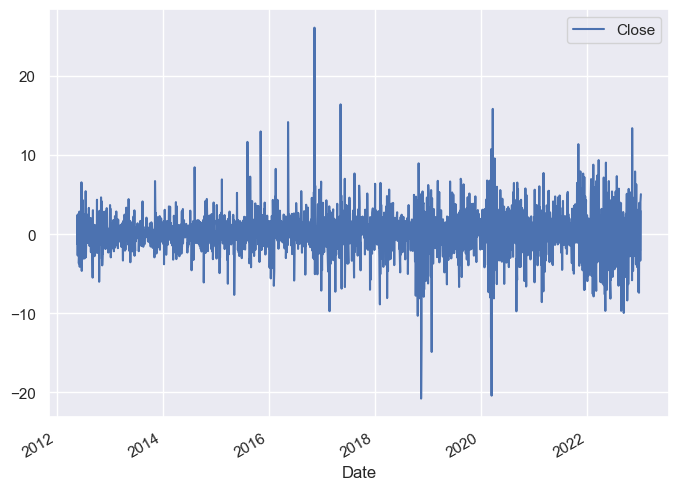

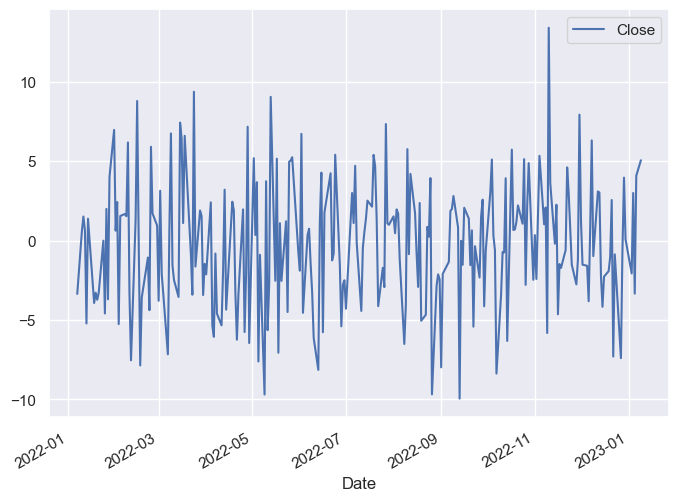

In [64]:
tick_ret.plot()

# For the last year worth of data we can plot the graph using the following:
tick_ret[-252:].plot()
### In the one year data we can see there is a lot less noise

<h3> 6. Describing function using descreptive statistics, default assumes we are dealing with a sample Pandas also deals with missing vallues by omitting them </h3>

In [65]:
tick_ret.describe()

,Close
count,2677.000000
mean,0.150613
std,2.743324
min,-20.770000
25%,-1.100000
50%,0.180000
75%,1.460000
max,26.090000


<h3> 7. An alternative table of descriptives from scipy stats </h3>

In [69]:
n, minmax, mean, var, skew, kurt = stats.describe(tick_ret)
mini, maxi = minmax #minmax is a tuple so we break it
std = np.sqrt(var)
print("The skewness is:", skew, "; and the kurtosis is:", kurt)

The skewness is: [0.05417159] ; and the kurtosis is: [8.21955295]


<ul>
    <li> Looking just a the skewness we see a suggested tilt towards the right. </li>
    <ul>
        <li> As the skewness of zero would indicate no skewness; and positive skewness would indicate a tilt towards the right and negative skewness a tilt towards the left. (This skewness information is not enough to be meaningful.) </li>
    </ul>
    <li> Looking at the kurtosis we see a different story. The kurtosis here can be constituted to being a Fischer Kutosis. </li>
    <ul>
        <li> This would mean the Kurtosis has been normalized. A Normal distribution has a Kurtosis of 3 and is mesokurtic. </li>
        <li> The excess kurtosis of 8.2 here shows a huge departure from Normality. Hence, the distribution here is peaked. Much more peaked than would be expected from a normal distribution. </li>
        <li> This would point to an inference that there are a lot more observations in the center than we would expect in a normally distributed population. </li>
    </ul>
    <li> This also points to the distribution having fatter tails. </li>
</ul>

<h3> 8. For comparison we generate random numbers that follow normal distribution </h3>

<ul>
    <li> Comparing the daily price change to a sample of the same size that is drawn from a normal distribution just to observe what it looks like. </li>
</ul>

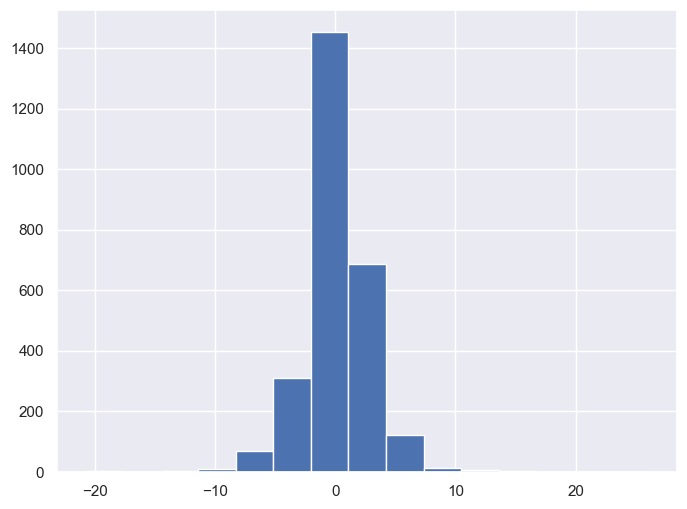

In [70]:
plt.hist(tick_ret, bins = 15);

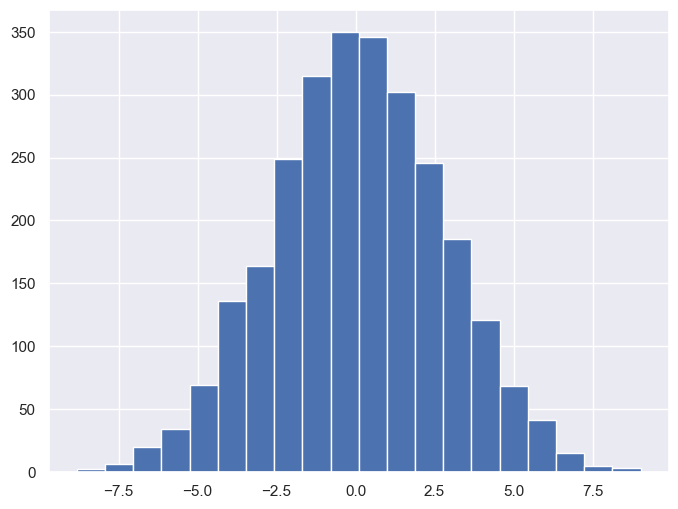

In [71]:
x = norm.rvs(mean, std, n)
plt.hist(x, bins = 20);

<h2> Is price change normally distributed? </h2>

<h3> 9. Testing Kurtosis </h3>
<ul> The test is conducted on both the normal veriable that is generated and the tickers returns. </ul>
<ul> 
    <li> Null Hypothesis: Sample is drawn from a population where where the underlying kurtosis is that of a normally distributed variable </li>
    <li> Alternate Hypothesis: Sample is not drawn from a population where where the underlying kurtosis is that of a normally distributed variable </li>
</ul>

In [72]:
x_test = stats.kurtosistest(x)
tick_ret1 = round(np.log(tick_close).diff() * 100, 2)
tick_ret1.dropna(inplace = True)
tick_test = stats.kurtosistest(tick_ret1)
print(f'{"      Test statistic":20}{"p-value": >15}')
print(f'{" "*5}{"-"* 30}')
print(f"x:{x_test[0]:>17.2f}{x_test[1]:16.4f}")
print(f"META: {tick_test[0]:13.2f}{tick_test[1]:16.4f}")


      Test statistic        p-value
     ------------------------------
x:            -1.30          0.1948
META:         20.61          0.0000


<ul>
    <li> For a hypothesis test most of the times we need a test statistc in excess of negative 2 or positive 2 to start rejecting a hypothesis.</li>
    <ul>
        <li> But we don't know where the critical value is here.</li>
    </ul>
    <li> Hence, it is much easier to interpret the <b>p-value</b> that we get from the kurtosis test. </li>
    <ul>
        <li> At 0.195 essentially we can infer that there is a 19.5% chance that we are making a mistake rejecting the null hypothesis. </li> 
    </ul>
    <li> The Amazon data tells a different story though. </li>
    <ul>
        <li> Based of the percision of the test it is seen that the p-value is zero. Though it isn't really zero but certainly tending towards it </li>
        <li> The test statistic is much larger, way past the negative two and positive two. </li>
        <li> Basically, we are to conclude that we should reject the <b>null hypothesis</b> and conclude that the price change of the particular Ticker <b><u>cannot</u></b> be described as <b>normally distributed</b>. </li>
    </ul>
    <li> We can run this on other stocks to see how well they measure up.</li>
</ul>

<h3> 10. Plot histogram of Price changes with Normal Curve overlay </h3>

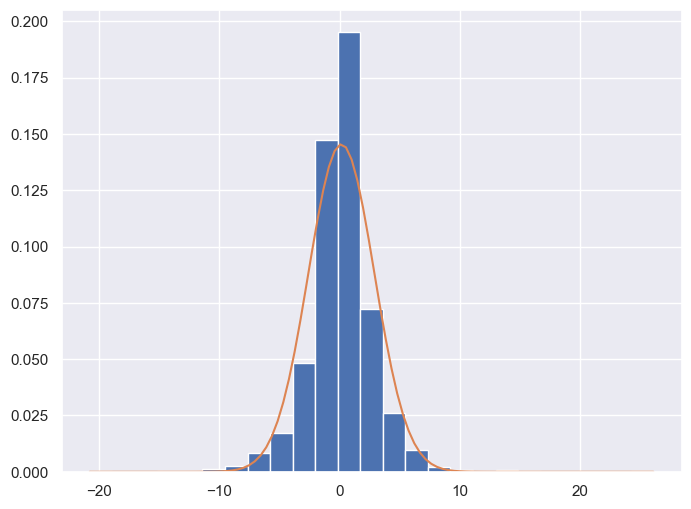

In [73]:
plt.hist(tick_ret,bins = 25, edgecolor = 'w', density = True)
overlay = np.linspace(mini,maxi,100)
plt.plot(overlay, norm.pdf(overlay, mean, std))

<ul>
    <li> We can see that the actual daily price change lies way outside the normal distribution.</li>
</ul>

<h2> Is daily price change significantly different from zero? </h2>
<ul>
    <li> Is there a bias for the daily price change on average increase or on average decrease? </li>
</ul>

<h3> 11. Conduct simple hypothesis test </h3>
<ul>
    <li> This is a two-tailed T-test. </li>
    <li> Null Hypothesis: The return is zero. </li>
    <ul>
        <li> If the return is significantly smaller or larger than zero, there is directional bias. Then we move on to the Alternate Hytpothesis. </li>
    </ul>
    <li> This is two-tailed </li> 
    <ul>
        <li> We don't have a reason to believe that this bias if it exists is negative or positive we want to test if its different from zero. </li>
    </ul>
    <li> Alternate Hypothesis: The return is not zero. </li>
</ul>

In [74]:
stats.ttest_1samp(tick_ret1,0,alternative = 'two-sided')

Ttest_1sampResult(statistic=2.840589501634381, pvalue=0.004537065214181795)

<ul>
    <li> Going back to the kurtosis test we said the statistic is a hard to interpret. </li>
    <li> Here, we see the statistic is greater than 2. But we still don't know where that critical value is. </li>
    <li> The <b><u>p-value</u></b> is easier to interpret though. If the <b>alpha</b> coming in was 0.05 and we have a <b>p-value</b> of less than that, we can can <b> reject the null hypothesis </b> that the price change does not have any directional bias (the return is 0). </li>
    <ul>
        <li> The problem with this inference is that the sample is so large that we could easily prove anything. </li>
        <ul>
            <li> With a really large sample, any small variation away from whatever the null hypothesized mean is, is going to look significant.</li>
        </ul>
    </ul>
    <li> In the kurtosis test a large sample works better.
    <ul>
        <li> But in case of simple comparison of the mean of the sample to the population mean it works in the opposite direction. </li>
    </ul>  
</ul>

<ul>
    <li> Null hypothesis can be rejected as the P-value is less than 0.5. </li>
</ul>

<i> As the sample is too large for the T-test we make the sample smaller and take a sample of one year. </i>

In [ ]:
stats.ttest_1samp(tick_ret1.sample(252),0,alternative = 'two-sided')

Ttest_1sampResult(statistic=1.909553204283917, pvalue=0.05733081570714618)

<ul>
    <li> Looking at the 1 year sample we see a very different result.</li>
    <li> A test statistic of just less than 2 and a p-value is just over 0.05.</li>
    <ul>
        <li> There is only a 5.7% chance that if the null hypothesis is rejected that we will be wrong </li>
    </ul>
    <li> Hence, it can be concluded that the null hypothesis is rejected.</li>
</ul>

<h2> Can price movement be described as a random walk? </h2>
<ul>
    <li> If the price movement is a random walk then it will be hard to predict. </li>
    <li> The best predictor would be forecasting tomorrow's price using todays. </li>
</ul>

<h3> 12. Creating price lags </h3>
<ul>
    <li> Using the simple linear regression model we will determine if the prices are a random walk or not. </li>
</ul>

In [ ]:
tick_close = pd.DataFrame(tick_close, columns = ['Close'])
tick_close['lag_1'] = tick_close.Close.shift(1)
tick_close['lag_2'] = tick_close.Close.shift(2)
tick_close.dropna(inplace = True)
tick_close.head()

,Close,lag_1,lag_2
Date,,,
2012-05-22 00:00:00-04:00,2.785378,2.819794,2.771612
2012-05-23 00:00:00-04:00,2.854209,2.785378,2.819794
2012-05-24 00:00:00-04:00,2.778495,2.854209,2.785378
2012-05-25 00:00:00-04:00,2.845032,2.778495,2.854209
2012-05-29 00:00:00-04:00,2.918453,2.845032,2.778495


<h3> 13. Fit Linear Model </h3>

In [ ]:
lr = np.linalg.lstsq(tick_close[['lag_1', 'lag_2']], tick_close['Close'], rcond = None)[0]
lr

array([0.95496448, 0.04500047])

<ul>
    <li> What we can infer from this model is that 95% of tomorrow's price can be predicted by today's. </li>
    <li> And the rest of the price can be predicted with the second lag. </li> 
</ul>

In [ ]:
tick_close['Predict'] = np.dot(tick_close[['lag_1', 'lag_2']], lr)
tick_close.head()

,Close,lag_1,lag_2,Predict
Date,,,,
2012-05-22 00:00:00-04:00,2.785378,2.819794,2.771612,2.817527
2012-05-23 00:00:00-04:00,2.854209,2.785378,2.819794,2.786830
2012-05-24 00:00:00-04:00,2.778495,2.854209,2.785378,2.851012
2012-05-25 00:00:00-04:00,2.845032,2.778495,2.854209,2.781805
2012-05-29 00:00:00-04:00,2.918453,2.845032,2.778495,2.841938


<h3> 14. Visualizing the Close Price and Predicted Price </h3>

<AxesSubplot: xlabel='Date'>

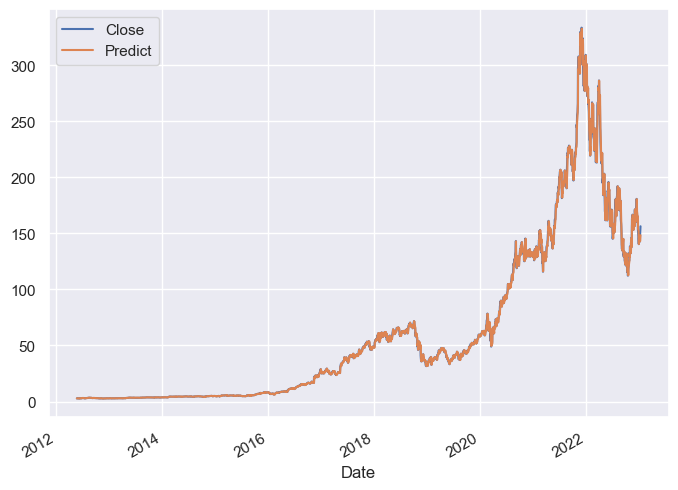

In [ ]:
tick_close[['Close', 'Predict']].plot()

<AxesSubplot: xlabel='Date'>

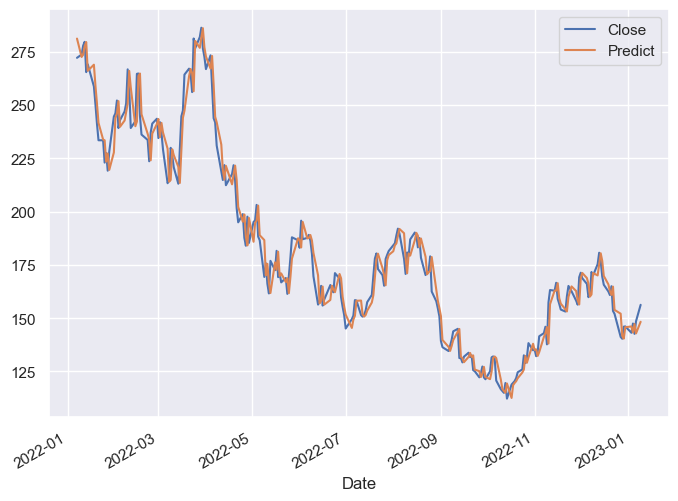

In [ ]:
tick_close.iloc[-252:][['Close', 'Predict']].plot()